In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Motivation

The motivation behind the analysis in this notebook is to investigate how sensitive the decoding accuracy over time is to leaving subsets of neurons out of the analsys. The idea is that if only a few neurons are coding for the stimulus, then decoding should be very sensitive to reducing the number of neurons. However, if the information is coded more distributed, decoding should fail gracefully with neuron loss.

In [2]:
# Import generic libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.io
import os, sys
import tqdm
from scipy.optimize import curve_fit
from pathlib import Path
import pickle

In [3]:
# Import local tools
sys.path.append(os.path.expanduser('~/projects/2017-kohl/repo/'))
from pynalysis import utils

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
sys.path.append(os.path.expanduser('/home/zenke/projects/2017-kohl/tensortools/'))
import tensortools as tt

In [5]:
# Import local OASIS installation
sys.path.append('../../OASIS')
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis import oasisAR1, oasisAR2

In [70]:
# Set file-name and path to analyze
stringid = "CGCC8.5a"
stringid = "CTBD2.1b"
# stringid = "AIGC1.1a"
# stringid = "GTRS1.5d"
filename = os.path.expanduser('/home/zenke/data/kohl/ca-data-large/2018/%s.mat'%stringid)

In [71]:
# Load data struct
dat = utils.load_mat_file(filename)

Not an old MAT struct. Trying to read as HDF5 for MATLAB v7.3 format instead


In [72]:
# Print contents
print("subject: %s"%stringid)
utils.print_file_content(dat)

subject: CTBD2.1b
imaging/
 date_2018_04_30
 ->area1 ['plane1', 'plane2', 'session_behaviour']
 ->area2 ['plane1', 'plane2', 'session_behaviour']
 ->area3 ['plane1', 'plane2', 'session_behaviour']
 date_2018_05_04
 ->area1 ['plane1', 'plane2', 'session_behaviour']
 ->area2 ['plane1', 'plane2', 'session_behaviour']
 ->area3 ['plane1', 'plane2', 'session_behaviour']
 ->area4 ['plane1', 'plane2', 'session_behaviour']


In [74]:
### Select dataset to analyze
area_name = "area4"
expspecifier = "date_2018_05_04/%s"%area_name
path="imaging/%s"%expspecifier
area=dat.get(path)
utils.get_hdf5group_keys(area)

['plane1', 'plane2', 'session_behaviour']

In [75]:
print("%s/%s"%(stringid,expspecifier))

CTBD2.1b/date_2018_05_04/area4


In [76]:
plane1=area['plane1']
plane2=area['plane2']
sessbehav=area['session_behaviour']

In [77]:
# Check how many unit are in each plane
print(plane1['fluoresence_corrected'].shape[1])
print(plane2['fluoresence_corrected'].shape[1])

223
78


In [78]:
print(utils.get_hdf5group_keys(plane1))

['fRate', 'fluoresence_corrected', 'info', 'is_red', 'position', 'raw_fluoresence', 'raw_neuropil', 'spike_amps', 'spike_timings', 'trialByTrialAmps', 'trialByTrialFlu', 'trialByTrialSpikes']


In [79]:
# Extract frame rate from struct
frate = area['plane1/fRate'][0,0]
print("Frame rate %f"%frate)

Frame rate 15.025166


In [80]:
# Merge fluorescence corrected from multiple planes
fluo_raw = np.concatenate([plane1['fluoresence_corrected'], plane2['fluoresence_corrected']],axis=1).T
time = np.arange(len(fluo_raw.T))*1.0/frate

In [81]:
fluo_raw.shape

(301, 30000)

In [82]:
# Select traces below saturation
fidx=fluo_raw.max(1)<6000

In [83]:
fluo = fluo_raw[fidx]
print(fluo.shape)

(301, 30000)


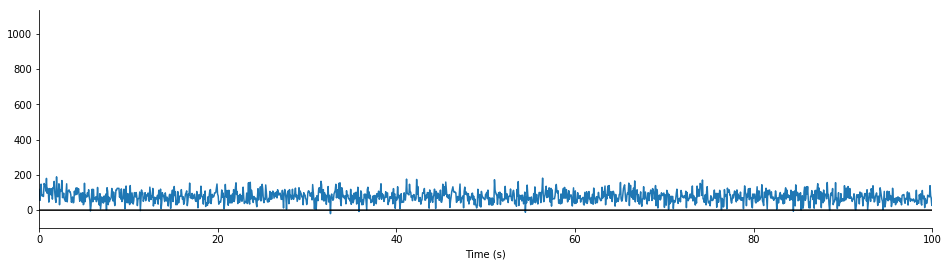

In [84]:
sample_id = 3
plt.figure(figsize=(16,4))
time = np.arange(len(fluo_raw.T))*1.0/frate
p0 = plt.plot(time, fluo[sample_id].T)
# p0 = plt.plot(time, traces[sample_id].T)
p0=plt.plot(time, np.zeros(time.shape), color='black')
plt.xlabel("Time (s)")
plt.xlim(0,100)
sns.despine()

In [85]:
# Extract positions
tmp = []
for pos in plane1['position']:
    tmp.append(pos)
positions_plane1 = np.array(tmp).T

tmp = []
for pos in plane2['position']:
    tmp.append(pos)
positions_plane2 = np.array(tmp).T

positions_pivot = len(positions_plane1)

In [86]:
print(utils.get_hdf5group_keys(sessbehav))

['ID', 'TTLs', 'area', 'area1', 'area2', 'area3', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']


In [87]:
# Extract event timing
motor_events = ['motor_start', 'motor_back', 'motor_atWhisk']
event_fields = []
event_fields.extend(motor_events)
event_fields.extend(['velocity', 'stim_speed', 'stim_position'])
# event_fields = ['motor_start']

events = {}
for f in event_fields:
    events[f] = np.array(sessbehav[f])
t_stim = events['motor_start']

# discard last event
events['motor_start'] = events['motor_start'][:-1]
events['motor_atWhisk'] = events['motor_atWhisk'][:-1]
events['stim_position'] = events['stim_position'][:-1]
events['stim_speed'] = events['stim_speed'][:-1]

In [90]:
# select only fast events
# sel=events['stim_speed']==840

In [91]:
# events['motor_start'] = events['motor_start'][sel]
# events['motor_atWhisk'] = events['motor_atWhisk'][sel]
# events['stim_position'] = events['stim_position'][sel]
# events['stim_speed'] = events['stim_speed'][sel]

# Preprocessing

In [92]:
events.keys()

dict_keys(['motor_start', 'stim_position', 'motor_atWhisk', 'motor_back', 'velocity', 'stim_speed'])

In [93]:
def plot_trace(groundtruth=False):
    plt.figure(figsize=(20,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    if groundtruth:
        plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)
    plt.plot(y, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    # simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k,k],[-.1,1], c='r', zorder=-11, clip_on=False)
    plt.ylim(0,1.3)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));
    # simpleaxis(plt.gca())
    print("Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1])
    print("Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1])

In [94]:
# Init values for OASIS

# tau_d = 270e-3 # GCAMP6M
tau_d = 142e-3 # GCAMP6F

ginit = (np.exp(-1.0/(frate*tau_d)),)
ginit = (None,)
# ginit=(None,) # Single exponential, fit time constant
# ginit = (0.70,) # Single exponential, fix time constant
print(ginit)

(None,)


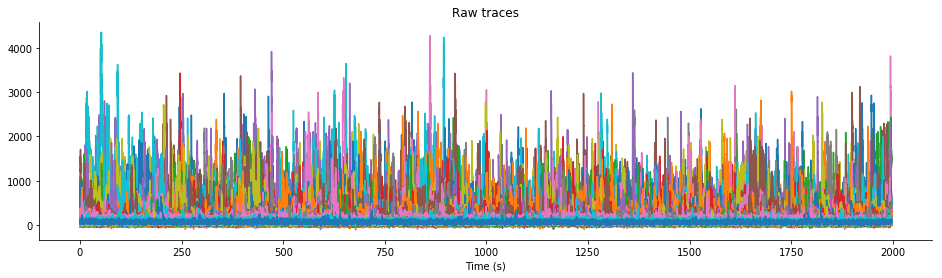

In [95]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, fluo.T)
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.title("Raw traces")
plt.xlabel("Time (s)")
# plt.ylim(0,1)
sns.despine()

In [124]:
# Run OASIS on each fluorescence trace
traces = []
spikes = []
ret_values = []
for idx in tqdm.trange(len(fluo)):
# for idx in tqdm.trange(10):
    y = np.array(fluo[idx],dtype=float)
    c, s, b, g, lam = r = deconvolve(y, g=ginit, penalty=1)
    traces.append(c)
    spikes.append(s)
    # print(g)
    ret_values.append(r)
traces = np.array(traces)
spikes = np.array(spikes)

100%|██████████| 301/301 [00:06<00:00, 43.41it/s]


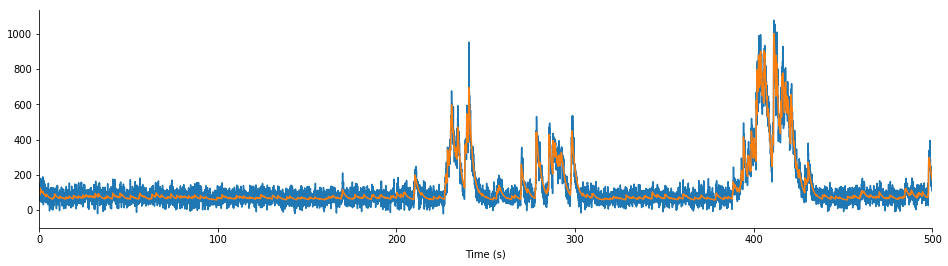

In [125]:
sample_id = 3
smp = ret_values[sample_id]
plt.figure(figsize=(16,4))
p0=plt.plot(time, fluo[sample_id].T)
p0=plt.plot(time, smp[0].T+smp[2])
plt.xlabel("Time (s)")
plt.xlim(0,500)
sns.despine()

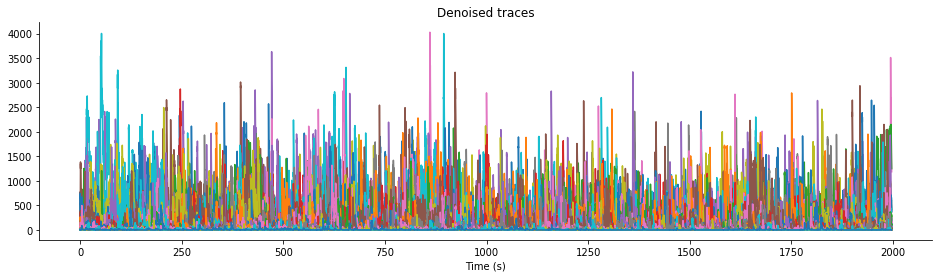

In [126]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, traces.T)
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.xlabel("Time (s)")
plt.title("Denoised traces")
sns.despine()

# Sanity checks

##  A look at effective data dimension with PCA

In [127]:
from sklearn.decomposition import PCA, NMF, FastICA
nb_components = 60

In [128]:
X = np.array(traces.T)

pca = PCA()
pca.fit(X)
varexp_denoised = np.cumsum(pca.explained_variance_ratio_)

In [129]:
X = np.array(fluo.T)
time = np.arange(len(X))*1.0/frate
pca = PCA()
pca.fit(X)
varexp_raw = np.cumsum(pca.explained_variance_ratio_)

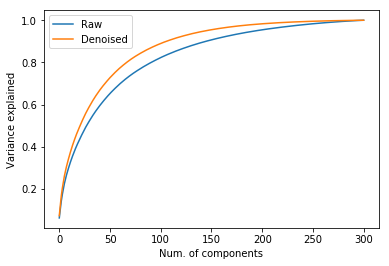

In [130]:
plt.plot(varexp_raw, label="Raw")
plt.plot(varexp_denoised, label="Denoised")
plt.legend()
plt.xlabel("Num. of components")
plt.ylabel("Variance explained")

# Trial binning of data

In [131]:
def datamatrix2tensor(data, event_times, toff_after, toff_before=0):
    """ Slices flat data matrix into trial based tensor.
    
    Expects data to be time x unit.
    
    Returns: A tensor which is trial x time x unit.
    """
    trials = []
    nb_frames = data.shape[0]
    for ev in event_times:
        fr = int(ev)
        if fr<toff_before or fr>nb_frames-toff_after: continue
        s = data[fr-toff_before:fr+toff_after]
        trials.append(s)
    return np.array(trials)

In [132]:
def tensorbin(data, bin_size=10):
    """ Takes data tensor and bins it """
    nb_bins = data.shape[1]//bin_size
    #print(data.shape)
    binned = []
    for i in range(nb_bins):
        a = data[:,i*bin_size:(i+1)*bin_size,:]
        # print(a.shape)
        binned.append(np.sum(a,axis=1))
    return np.transpose(np.array(binned),axes=[1,0,2])
    
def bin_data(data, event_times, toff_after=60, toff_before=0, bin_size=10, axis=1):
    datatensor = datamatrix2tensor(data,event_times,toff_before=toff_before, toff_after=toff_after)
    #     return datatensor.mean(axis=axis)
    return tensorbin(datatensor, bin_size)

# Decoding stimulus from neural data using SVM Classifier

In [133]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.preprocessing

In [134]:
def split_dataset(dataset, split=0.8, shuffle=True):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    idx = np.arange(len(x))
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:s]
    x_valid = x[s:]
    y_train = y[:s]
    y_valid = y[s:]
    return (x_train, y_train),(x_valid, y_valid)

In [135]:
def fuse_dataset(data, labels, standardize=True):
    d = data.reshape((data.shape[0],-1))
    if standardize:
        scaler = sklearn.preprocessing.Normalizer()
        d = scaler.fit_transform(d)
    return d,labels

In [136]:
def get_acc(dataset):
    pred=svc.predict(dataset[0])
    acc=(pred==dataset[1]).mean()
    return acc

In [137]:
def get_acc_all_times(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    dataset = fuse_dataset(data_selection,labels)
    clf = SVC(kernel=kernel, C=1)
    scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
    return scores



def scan_acc_time(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer over time.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    results = []
    for t in range(data_selection.shape[1]):
        partial_data = data_selection[:,t,:]
        dataset = fuse_dataset(partial_data,labels)
        clf = SVC(kernel=kernel, C=1)
        scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
        results.append(scores)
    results = np.array(results)
    return results

In [138]:
def cyclic_split_dataset(dataset, split=0.8, splitid=0):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    k = splitid
    # split data cyclically
    o = int((1.0-split)*n)
    if (1.0-split)*k>1.0:
        print("Cannot have more than %i different cyclic splits."%(1.0/(1.0-split)))
        raise ValueError
    x_train = np.concatenate( [x[:k*o], x[(k+1)*o:]], axis=0 )
    x_valid = x[k*o:(k+1)*o]
    y_train = np.concatenate( [y[:k*o], y[(k+1)*o:]], axis=0 )
    y_valid = y[k*o:(k+1)*o]
    return (x_train, y_train),(x_valid, y_valid)

def get_trial_predictions(all_data, labels, units="all", kernel="linear", splitid=0):
    """ Fits SVC on trials and returns array for correct trials==True for validation set
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    dataset = fuse_dataset(data_selection,labels)
    train,test = cyclic_split_dataset(dataset, splitid=splitid)
    clf = SVC(kernel=kernel, C=1)
    clf.fit(*train)
    pred=clf.predict(test[0])
    acc=(pred==test[1]).mean()
    print(acc)
    return clf.predict(test[0])==test[1]

In [111]:
# How many frames before and after the onset signal we use for classification
frames_before = 15
frames_after  = 75

# Create data tensor from denoised traces for all trials
full_data = datamatrix2tensor(traces.T, events['motor_atWhisk'], toff_before=frames_before, toff_after=frames_after)
print("Datatensor shape: ",full_data.shape)

# Creat labels for data
labels = stim_pos = events['stim_position'].ravel()
print("Unique labels: ",np.unique(labels))

Datatensor shape:  (294, 90, 301)
Unique labels:  [45. 53. 61. 69.]


In [112]:
vel = -events['velocity'].ravel()
run_data = datamatrix2tensor(vel, events['motor_atWhisk'], toff_before=frames_before, toff_after=frames_after)

In [113]:
run_data = run_data.mean(1)

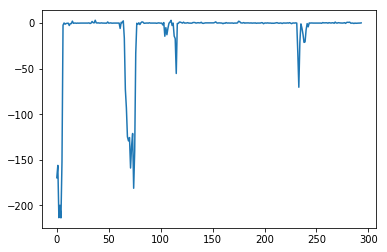

In [114]:
plt.plot(run_data)

# Leave some out analysis both planes

In [115]:
# Do the same analysis for each plane separately
nb_plane1 = plane1['fluoresence_corrected'].shape[1]
nb_plane2 = plane2['fluoresence_corrected'].shape[1]

In [116]:
mean_performance = {}

In [117]:
# Compute classification accuracy for each time bin
kernel = "linear"
results_all = scan_acc_time(full_data, labels, kernel=kernel)

# Compute classification accuracy for all time bins together
acc_total = get_acc_all_times(full_data, labels)
print(acc_total.mean(),acc_total.std())

0.4214205666795593 0.1049454065581234


In [118]:
# redo analysis for random subsets of m neurons
n = traces.shape[0]
frac=0.9
m = int(frac*n)
print("nb_units=%i"%m)
results_subsets = []
total_acc_subsets = []
for r in range(10):
    idx = list(range(n))
    np.random.shuffle(idx)
    idx = idx[:m]
    # print(idx)
    res = scan_acc_time(full_data, labels, kernel=kernel, units=idx)
    results_subsets.append(res)
    acc = get_acc_all_times(full_data, labels, units=idx)
    total_acc_subsets.append(acc)

nb_units=270


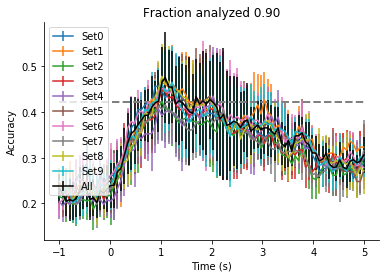

In [119]:
x = np.linspace(-frames_before/frate,frames_after/frate,full_data.shape[1])
def plot_res(x, results, **kwargs):
    means = results.mean(1)
    stdev = results.std(1)
    return plt.errorbar(x, means, yerr=stdev, **kwargs)

for i,res in enumerate(results_subsets):
    plot_res(x, res, label="Set%i"%i)
plot_res(x, results_all, label="All", color='black')


m,s=acc_total.mean(),acc_total.std()
plt.plot([x[0], x[-1]], [m, m], color='gray', linestyle='--', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title("Fraction analyzed %.2f"%frac)
sns.despine()

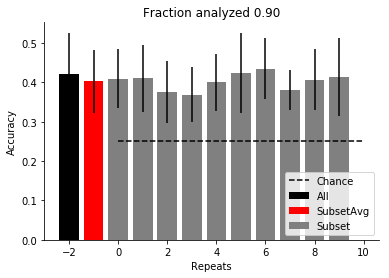

In [120]:
m = len(total_acc_subsets)
ind = range(m)
width = 0.8
means = [ acc.mean() for acc in total_acc_subsets]
stds = [ acc.std() for acc in total_acc_subsets]
omean = np.array(means).mean() # overall mean
ostdev = np.sqrt((np.array(stds)**2).sum()/m) # overall stdev 
# TODO: check if m should be outside of sqrt, probably not, but just ot make sure
rects_all = plt.bar([-2], [acc_total.mean()], width,
                color='black',
                yerr=[acc_total.std()], label="All")
rects_avg = plt.bar([-1], [omean], width,
                color='red',
                yerr=[ostdev], label="SubsetAvg")
rects1 = plt.bar(ind, means, width,
                color='gray',
                yerr=stds, label="Subset")
plt.plot([0,10],[0.25,0.25],label="Chance",color="black",ls="--")
plt.title("Fraction analyzed %.2f"%frac)
plt.xlabel("Repeats")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
sns.despine()

In [121]:
mean_performance[frac] = (omean, ostdev) 

In [122]:
print(mean_performance)

{0.9: (0.40262989299138174, 0.0799597980970753)}


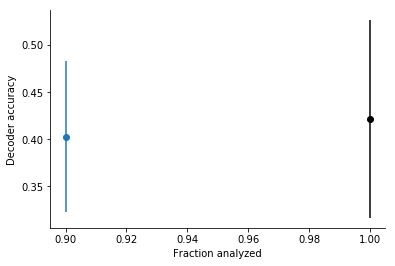

In [123]:
x = []
y = []
dy = []
for k in mean_performance.keys():
    x.append(k)
    a,b = mean_performance[k]
    y.append(a)
    dy.append(b)
    
# plt.errorbar?
plt.errorbar(x,y,yerr=dy, ls='None', fmt='o')
plt.errorbar([1.0],[acc_total.mean()],yerr=[acc_total.std()], ls='None', fmt='o', color="k")
plt.xlabel("Fraction analyzed")
plt.ylabel("Decoder accuracy")
sns.despine()
plt.savefig("leave_some_out_summary.pdf")

# Leave some out analysis on individual planes (plane1)

In [57]:
def get_leave_some_out_performance(units, nb_repeats=10):
    """ Compute the summary performance curve for arbitrary subsets of units.
    
    Args:
    units : a list of units to run the anlaysis on
    
    Returns : a dictionary in which keys are the fractions of units used in the analysis which contains 
                tuples with mean and stdev.
    """
    n = len(units)
    mean_performance = {}
    for frac in np.linspace(0.1,0.9,9):
        m = int(frac*n)
        print("frac=%.2f, nb_units=%i"%(frac,m))
        results_subsets = []
        total_acc_subsets = []
        for r in range(nb_repeats):
            idx = list(units)
            np.random.shuffle(idx)
            idx = idx[:m]
            res = scan_acc_time(full_data, labels, kernel=kernel, units=idx)
            results_subsets.append(res)
            acc = get_acc_all_times(full_data, labels, units=idx)
            total_acc_subsets.append(acc)

        means = [ acc.mean() for acc in total_acc_subsets]
        stds = [ acc.std() for acc in total_acc_subsets]
        omean = np.array(means).mean() # overall mean
        ostdev = np.sqrt((np.array(stds)**2).sum()/m)
    
        mean_performance[frac] = dict(mean=omean, stdev=ostdev, nb_units=m)
    return mean_performance

In [58]:
units = list(range(nb_plane1+nb_plane2)) # select all neurons from both planes
perf_both = get_leave_some_out_performance(units)

frac=0.10, nb_units=6
frac=0.20, nb_units=12
frac=0.30, nb_units=19
frac=0.40, nb_units=25
frac=0.50, nb_units=32
frac=0.60, nb_units=38
frac=0.70, nb_units=44
frac=0.80, nb_units=51
frac=0.90, nb_units=57


In [59]:
units = list(range(0,nb_plane1)) # select neurons from Plane1
perf_plane1 = get_leave_some_out_performance(units)

frac=0.10, nb_units=3
frac=0.20, nb_units=6
frac=0.30, nb_units=9
frac=0.40, nb_units=12
frac=0.50, nb_units=16
frac=0.60, nb_units=19
frac=0.70, nb_units=22
frac=0.80, nb_units=25
frac=0.90, nb_units=28


In [60]:
units = list(np.arange(0,nb_plane2)+nb_plane1) # select neurons from Plane2
perf_plane2 = get_leave_some_out_performance(units)

frac=0.10, nb_units=3
frac=0.20, nb_units=6
frac=0.30, nb_units=9
frac=0.40, nb_units=12
frac=0.50, nb_units=16
frac=0.60, nb_units=19
frac=0.70, nb_units=22
frac=0.80, nb_units=25
frac=0.90, nb_units=28


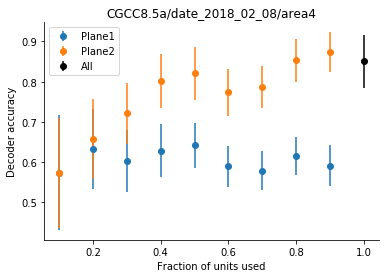

In [61]:
def plot_mperf_vs_frac(mperf, **kwargs):
    x = []
    y = []
    dy = []
    for k in mperf.keys():
        dat = mperf[k]
        x.append(k)
        a = dat['mean']
        b = dat['stdev']
        y.append(a)
        dy.append(b)
    plt.errorbar(x,y,yerr=dy, ls='None', fmt='o', **kwargs)

    
plot_mperf_vs_frac(perf_plane1, label="Plane1")
plot_mperf_vs_frac(perf_plane2, label="Plane2")
plt.errorbar([1.0],[acc_total.mean()],yerr=[acc_total.std()], ls='None', fmt='o', color="k", label="All")
plt.xlabel("Fraction of units used")
plt.ylabel("Decoder accuracy")
plt.legend()
plt.title("%s/%s"%(stringid,expspecifier))
sns.despine()
plt.savefig("leave_some_out_summary_frac.pdf")

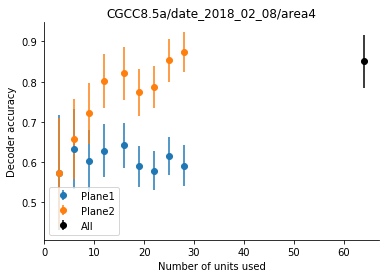

In [62]:
def plot_mperf_vs_nbunits(mperf, **kwargs):
    x = []
    y = []
    dy = []
    for k in mperf.keys():
        dat = mperf[k]
        x.append(dat['nb_units'])
        a = dat['mean']
        b = dat['stdev']
        y.append(a)
        dy.append(b)
    plt.errorbar(x,y,yerr=dy, ls='None', fmt='o', **kwargs)
    
plot_mperf_vs_nbunits(perf_plane1, label="Plane1")
plot_mperf_vs_nbunits(perf_plane2, label="Plane2")
plt.errorbar([nb_plane1+nb_plane2],[acc_total.mean()],yerr=[acc_total.std()], ls='None', fmt='o', color="k", label="All")
plt.xlabel("Number of units used")
plt.ylabel("Decoder accuracy")
plt.legend()
plt.title("%s/%s"%(stringid,expspecifier))
sns.despine()
plt.savefig("leave_some_out_summary_num.pdf")

In [63]:
print(perf_plane1)

{0.1: {'nb_units': 3, 'stdev': 0.14232003626519069, 'mean': 0.5741558441558442}, 0.2: {'nb_units': 6, 'stdev': 0.09972758256777059, 'mean': 0.6332467532467534}, 0.6: {'nb_units': 19, 'stdev': 0.05133514793152094, 'mean': 0.5893506493506495}, 0.8: {'nb_units': 25, 'stdev': 0.04775078197096334, 'mean': 0.6147619047619047}, 0.30000000000000004: {'nb_units': 9, 'stdev': 0.07716456119329038, 'mean': 0.603116883116883}, 0.9: {'nb_units': 28, 'stdev': 0.05055716308991446, 'mean': 0.5914285714285714}, 0.7000000000000001: {'nb_units': 22, 'stdev': 0.04827161888370144, 'mean': 0.579090909090909}, 0.4: {'nb_units': 12, 'stdev': 0.06598336126777397, 'mean': 0.6283982683982685}, 0.5: {'nb_units': 16, 'stdev': 0.05618561502194992, 'mean': 0.6421645021645022}}
